<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Import-modules" data-toc-modified-id="Import-modules-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import modules</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#Data-Preprocessing" data-toc-modified-id="Data-Preprocessing-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Data Preprocessing</a></span></li><li><span><a href="#Benchmarking" data-toc-modified-id="Benchmarking-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Benchmarking</a></span></li><li><span><a href="#Categorical-Variables-in-Tree-based-Models" data-toc-modified-id="Categorical-Variables-in-Tree-based-Models-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Categorical Variables in Tree-based Models</a></span></li><li><span><a href="#References" data-toc-modified-id="References-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>References</a></span></li></ul></div>

# Introduction
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-warning">
<font color=black>

**What?** LightGBM API walkthrough and a discussion about categorical features in tree-based models

</font>
</div>

# Import modules
<hr style = "border:2px solid black" ></hr>

In [1]:
import os
import re
import time
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from lightgbm import plot_importance
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder

# LightGBM
<hr style = "border:2px solid black" ></hr>

[Gradient boosting](http://nbviewer.jupyter.org/github/ethen8181/machine-learning/blob/master/trees/gbm/gbm.ipynb) is a machine learning technique that produces a prediction model in the form of an ensemble of weak classifiers, optimizing for a differentiable loss function. One of the most popular types of gradient boosting is gradient boosted trees, that internally is made up of an ensemble of week [decision trees](http://nbviewer.jupyter.org/github/ethen8181/machine-learning/blob/master/trees/decision_tree.ipynb). There are two different ways to compute the trees: level-wise and leaf-wise as illustrated by the diagram below:

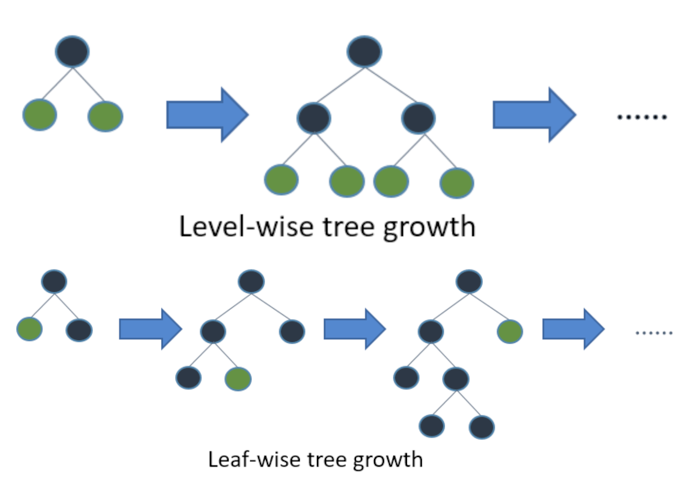

> The level-wise strategy adds complexity extending the depth of the tree level by level. As a contrary, the leaf-wise strategy generates branches by optimizing a loss.

The level-wise strategy grows the tree level by level. In this strategy, each node splits the data prioritizing the nodes closer to the tree root. The leaf-wise strategy grows the tree by splitting the data at the nodes with the highest loss change. Level-wise growth is usually better for smaller datasets whereas leaf-wise tends to overfit. Leaf-wise growth tends to [excel in larger datasets](http://researchcommons.waikato.ac.nz/handle/10289/2317) where it is considerably faster than level-wise growth.

A key challenge in training boosted decision trees is the [computational cost of finding the best split](https://arxiv.org/abs/1706.08359) for each leaf. Conventional techniques find the [exact split](https://arxiv.org/abs/1603.02754) for each leaf, and require scanning through all the data in each iteration. A different approach [approximates the split](https://arxiv.org/abs/1611.01276) by building histograms of the features. That way, the algorithm doesn’t need to evaluate every single value of the features to compute the split, but only the bins of the histogram, which are bounded. This approach turns out to be much more efficient for large datasets, without adversely affecting accuracy.

With all of that being said LightGBM is a fast, distributed, high performance gradient boosting that was open-source by Microsoft around  August 2016. The main advantages of LightGBM includes:

- Faster training speed and higher efficiency: LightGBM use histogram based algorithm i.e it buckets continuous feature values into discrete bins which fasten the training procedure.
- Lower memory usage: Replaces continuous values to discrete bins which result in lower memory usage.
- Better accuracy than any other boosting algorithm: It produces much more complex trees by following leaf wise split approach rather than a level-wise approach which is the main factor in achieving higher accuracy. However, it can sometimes lead to overfitting which can be avoided by setting the max_depth parameter.
- Compatibility with Large Datasets: It is capable of performing equally good with large datasets with a significant reduction in training time as compared to XGBoost.
- Parallel learning supported.


# Data Preprocessing
<hr style = "border:2px solid black" ></hr>

This notebook compares LightGBM with [XGBoost](http://nbviewer.jupyter.org/github/ethen8181/machine-learning/blob/master/trees/xgboost.ipynb), another extremely popular gradient boosting framework by applying both the algorithms to a dataset and then comparing the model's performance and execution time. Here we will be using the [Adult dataset](http://archive.ics.uci.edu/ml/datasets/Adult) that consists of 32561 observations and 14 features describing individuals from various countries. Our target is to predict whether a person makes <=50k or >50k annually on basis of the other information available. Dataset consists of 32561 observations and 14 features describing individuals.

In [3]:
def get_data():
    file_path = 'adult.csv'
    if not os.path.isfile(file_path):
        def chunks(input_list, n_chunk):
            """take a list and break it up into n-size chunks"""
            for i in range(0, len(input_list), n_chunk):
                yield input_list[i:i + n_chunk]

        columns = [
            'age',
            'workclass',
            'fnlwgt',
            'education',
            'education_num',
            'marital_status',
            'occupation',
            'relationship',
            'race',
            'sex',
            'capital_gain',
            'capital_loss',
            'hours_per_week',
            'native_country',
            'income'
        ]

        url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
        r = requests.get(url)
        raw_text = r.text.replace('\n', ',')
        splitted_text = re.split(r',\s*', raw_text)
        data = list(chunks(splitted_text, n_chunk=len(columns)))
        data = pd.DataFrame(data, columns=columns).dropna(axis=0, how='any')
        data.to_csv(file_path, index=False)

    data = pd.read_csv(file_path)
    return data


data = get_data()
print('dimensions:', data.shape)
data.head()

dimensions: (32561, 15)


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
label_col = 'income'
cat_cols = [
    'workclass',
    'education',
    'marital_status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'native_country'
]

num_cols = [
    'age',
    'fnlwgt',
    'education_num',
    'capital_gain',
    'capital_loss',
    'hours_per_week'
]

print('number of numerical features: ', len(num_cols))
print('number of categorical features: ', len(cat_cols))

number of numerical features:  6
number of categorical features:  8


In [5]:
label_encode = LabelEncoder()
data[label_col] = label_encode.fit_transform(data[label_col])
y = data[label_col].values
data = data.drop(label_col, axis=1)

print('labels distribution:', np.bincount(y) / y.size)

labels distribution: [0.75919044 0.24080956]


In [6]:
test_size = 0.1
split_random_state = 1234
df_train, df_test, y_train, y_test = train_test_split(
    data, y, test_size=test_size,
    random_state=split_random_state, stratify=y)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

print('dimensions:', df_train.shape)
df_train.head()

dimensions: (29304, 14)


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
0,52,Private,168381,HS-grad,9,Widowed,Other-service,Unmarried,Asian-Pac-Islander,Female,0,0,40,India
1,31,Private,134613,Assoc-voc,11,Married-civ-spouse,Exec-managerial,Wife,Black,Female,0,0,43,United-States
2,22,Private,68678,HS-grad,9,Married-civ-spouse,Sales,Husband,Black,Male,0,0,40,United-States
3,55,Private,110871,Bachelors,13,Married-civ-spouse,Sales,Husband,White,Male,0,0,40,United-States
4,35,?,117528,Assoc-voc,11,Married-civ-spouse,?,Wife,White,Female,0,0,40,United-States


We'll perform very little feature engineering as that's not our main focus here. The following code chunk only one hot encodes the categorical features. There will be follow up discussions on this in later section.

In [7]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse=False, dtype=np.int32)
one_hot_encoder.fit(df_train[cat_cols])
cat_one_hot_cols = one_hot_encoder.get_feature_names(cat_cols)

print('number of one hot encoded categorical columns: ', len(cat_one_hot_cols))
cat_one_hot_cols[:5]

number of one hot encoded categorical columns:  102


array(['workclass_?', 'workclass_Federal-gov', 'workclass_Local-gov',
       'workclass_Never-worked', 'workclass_Private'], dtype=object)

In [8]:
def preprocess_one_hot(df, one_hot_encoder, num_cols, cat_cols):
    df = df.copy()
    
    cat_one_hot_cols = one_hot_encoder.get_feature_names(cat_cols)

    df_one_hot = pd.DataFrame(
        one_hot_encoder.transform(df[cat_cols]),
        columns=cat_one_hot_cols
    )
    df_preprocessed = pd.concat([
        df[num_cols],
        df_one_hot
    ], axis=1)
    return df_preprocessed

In [9]:
df_train_one_hot = preprocess_one_hot(df_train, one_hot_encoder, num_cols, cat_cols)
df_test_one_hot = preprocess_one_hot(df_test, one_hot_encoder, num_cols, cat_cols)
print(df_train_one_hot.shape)
df_train_one_hot.dtypes

(29304, 108)


age                               int64
fnlwgt                            int64
education_num                     int64
capital_gain                      int64
capital_loss                      int64
                                  ...  
native_country_Thailand           int32
native_country_Trinadad&Tobago    int32
native_country_United-States      int32
native_country_Vietnam            int32
native_country_Yugoslavia         int32
Length: 108, dtype: object

# Benchmarking
<hr style = "border:2px solid black" ></hr>

The next section compares the xgboost and lightgbm's implementation in terms of both execution time and model performance. There are a bunch of other hyperparameters that we as the end-user can specify, but here we explicity specify arguably the most important ones. 

In [10]:
time.sleep(5)

lgb = LGBMClassifier(
    n_jobs=-1,
    max_depth=6,
    subsample=1,
    n_estimators=100,
    learning_rate=0.1,
    colsample_bytree=1,
    objective='binary',
    boosting_type='gbdt')

start = time.time()
lgb.fit(df_train_one_hot, y_train)
lgb_elapse = time.time() - start
print('elapse:, ', lgb_elapse)

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
elapse:,  0.327070951461792


In [11]:
time.sleep(5)

# raw xgboost
xgb = XGBClassifier(
    n_jobs=-1,
    max_depth=6,
    subsample=1,
    n_estimators=100,
    learning_rate=0.1,
    colsample_bytree=1,
    objective='binary:logistic',
    booster='gbtree')

start = time.time()
xgb.fit(df_train_one_hot, y_train)
xgb_elapse = time.time() - start
print('elapse:, ', xgb_elapse)

elapse:,  14.434311866760254


XGBoost includes a `tree_method = 'hist' `option that buckets continuous variables into bins to speed up training, we also set `grow_policy = 'lossguide'` to favor splitting at nodes with highest loss change, which mimics LightGBM.

In [12]:
time.sleep(5)

xgb_hist = XGBClassifier(
    n_jobs=-1,
    max_depth=6,
    subsample=1,
    n_estimators=100,
    learning_rate=0.1,
    colsample_bytree=1,
    objective='binary:logistic',
    booster='gbtree',
    tree_method='hist',
    grow_policy='lossguide')

start = time.time()
xgb_hist.fit(df_train_one_hot, y_train)
xgb_hist_elapse = time.time() - start
print('elapse:, ', xgb_hist_elapse)

elapse:,  0.8119819164276123


In [13]:
# evaluate performance
y_pred = lgb.predict_proba(df_test_one_hot)[:, 1]
lgb_auc = roc_auc_score(y_test, y_pred)
print('auc score: ', lgb_auc)

y_pred = xgb.predict_proba(df_test_one_hot)[:, 1]
xgb_auc = roc_auc_score(y_test, y_pred)
print('auc score: ', xgb_auc)

y_pred = xgb_hist.predict_proba(df_test_one_hot)[:, 1]
xgb_hist_auc = roc_auc_score(y_test, y_pred)
print('auc score: ', xgb_hist_auc)

auc score:  0.9352834593198379
auc score:  0.9348347355521263
auc score:  0.9351145431888891


In [14]:
# comparison table
results = pd.DataFrame({
    'elapse_time': [lgb_elapse, xgb_hist_elapse, xgb_elapse],
    'auc_score': [lgb_auc, xgb_hist_auc, xgb_auc]})
results.index = ['LightGBM', 'XGBoostHist', 'XGBoost']
results

,elapse_time,auc_score
LightGBM,0.327071,0.935283
XGBoostHist,0.811982,0.935115
XGBoost,14.434312,0.934835


From the resulting table, we can see that there isn't a noticeable difference in auc score between the two implementations. On the other hand, there is a significant difference in the time it takes to finish the whole training procedure. This is a huge advantage and makes LightGBM a much better approach when dealing with large datasets.

For those interested, the people at Microsoft has a blog that has a even more thorough benchmark result on various datasets. Link is included below along with a summary of their results:

> [Blog: Lessons Learned From Benchmarking Fast Machine Learning Algorithms](https://blogs.technet.microsoft.com/machinelearning/2017/07/25/lessons-learned-benchmarking-fast-machine-learning-algorithms/)
>
> Our results, based on tests on six datasets, are summarized as follows:

> - XGBoost and LightGBM achieve similar accuracy metrics.
> - LightGBM has lower training time than XGBoost and its histogram-based variant, XGBoost hist, for all test datasets, on both CPU and GPU implementations. The training time difference between the two libraries depends on the dataset, and can be as big as 25 times.
> - XGBoost GPU implementation does not scale well to large datasets and ran out of memory in half of the tests.
> - XGBoost hist may be significantly slower than the original XGBoost when feature dimensionality is high.

# Categorical Variables in Tree-based Models
<hr style = "border:2px solid black" ></hr>

Many real-world datasets include a mix of continuous and categorical variables. The property of the latter is that their values has zero inherent ordering. One major advantage of decision tree models and their ensemble counterparts, such as random forests, extra trees and gradient boosted trees, is that they are able to operate on both continuous and categorical variables directly (popular implementations of tree-based models differ as to whether they honor this fact). In contrast, most other popular models (e.g., generalized linear models, neural networks) must instead transform categorical variables into some numerical format, usually by one-hot encoding them to create a new dummy variable for each level of the original variable. e.g.

One drawback of one hot encoding is that they can lead to a huge increase in the dimensionality of the feature representations. For example, one hot encoding U.S. states adds 49 dimensions to to our feature representation.

To understand why we don't need to perform one hot encoding for tree-based models, we need to refer back to the logic of tree-based algorithms. At the heart of the tree-based algorithm is a sub-algorithm that splits the samples into two bins by selecting a feature and a value. This splitting algorithm considers each of the features in turn, and for each feature selects the value of that feature that minimizes the impurity of the bins.

This means tree-based models are essentially looking for places to split the data, they are not multiplying our inputs by weights. In contrast, most other popular models (e.g., generalized linear models, neural networks) would interpret categorical variables such as red=1, blue=2 as blue is twice the amount of red, which is obviously not what we want.

In [15]:
ordinal_encoder = OrdinalEncoder(dtype=np.int32)
ordinal_encoder.fit(df_train[cat_cols])

OrdinalEncoder(dtype=<class 'numpy.int32'>)

In [16]:
def preprocess_ordinal(df, ordinal_encoder, cat_cols, cat_dtype='int32'):
    df = df.copy()
    df[cat_cols] = ordinal_encoder.transform(df[cat_cols])
    df[cat_cols] = df[cat_cols].astype(cat_dtype)
    return df

In [17]:
df_train_ordinal = preprocess_ordinal(df_train, ordinal_encoder, cat_cols)
df_test_ordinal = preprocess_ordinal(df_test, ordinal_encoder, cat_cols)
print(df_train_ordinal.shape)
df_train_ordinal.dtypes

(29304, 14)


age               int64
workclass         int32
fnlwgt            int64
education         int32
education_num     int64
marital_status    int32
occupation        int32
relationship      int32
race              int32
sex               int32
capital_gain      int64
capital_loss      int64
hours_per_week    int64
native_country    int32
dtype: object

In [18]:
time.sleep(5)

lgb = LGBMClassifier(
    n_jobs=-1,
    max_depth=6,
    subsample=1,
    n_estimators=100,
    learning_rate=0.1,
    colsample_bytree=1,
    objective='binary',
    boosting_type='gbdt')

start = time.time()
lgb.fit(df_train_ordinal, y_train)
lgb_ordinal_elapse = time.time() - start
print('elapse:, ', lgb_ordinal_elapse)

y_pred = lgb.predict_proba(df_test_ordinal)[:, 1]
lgb_ordinal_auc = roc_auc_score(y_test, y_pred)
print('auc score: ', lgb_ordinal_auc)

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
elapse:,  0.2872467041015625
auc score:  0.9348548507555065


In [19]:
# comparison table
results = pd.DataFrame({
    'elapse_time': [lgb_ordinal_elapse, lgb_elapse, xgb_hist_elapse, xgb_elapse],
    'auc_score': [lgb_ordinal_auc, lgb_auc, xgb_hist_auc, xgb_auc]})
results.index = ['LightGBM Ordinal', 'LightGBM', 'XGBoostHist', 'XGBoost']
results

,elapse_time,auc_score
LightGBM Ordinal,0.287247,0.934855
LightGBM,0.327071,0.935283
XGBoostHist,0.811982,0.935115
XGBoost,14.434312,0.934835


From the result above, we can see that it requires even less training time without sacrificing any sort of performance. What's even more is that we now no longer need to perform the one hot encoding on our categorical features. The code chunk below shows this is highly advantageous from a memory-usage perspective when we have a bunch of categorical features.

In [20]:
print('OneHot Encoding')
print('number of columns: ', df_train_one_hot.shape[1])
print('memory usage: ', df_train_one_hot.memory_usage(deep=True).sum())
print()

print('Ordinal Encoding')
print('number of columns: ', df_train_ordinal.shape[1])
print('memory usage: ', df_train_ordinal.memory_usage(deep=True).sum())

OneHot Encoding
number of columns:  108
memory usage:  13362752

Ordinal Encoding
number of columns:  14
memory usage:  2344448


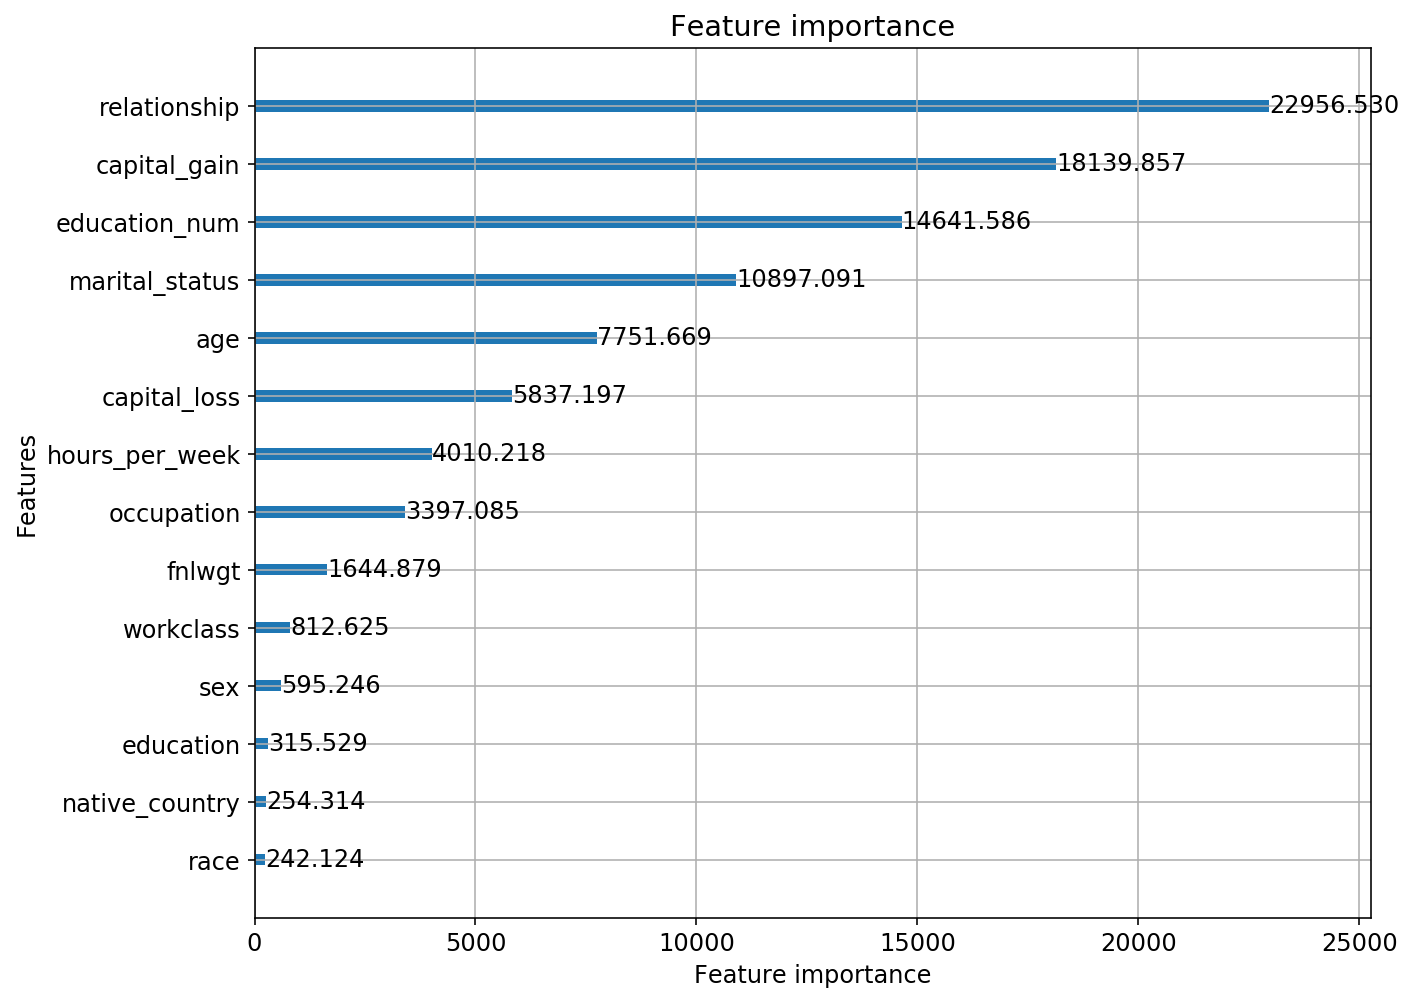

In [21]:
# plotting the feature importance just out of curiosity

# change default style figure and font size
plt.rcParams['figure.figsize'] = 10, 8
plt.rcParams['font.size'] = 12

# like other tree-based models, it can also output the
# feature importance plot
plot_importance(lgb, importance_type='gain')
plt.show()

For tuning LightGBM's hyperparameter, the documentation page has some pretty good suggestions. [LightGBM Documentation: Parameters Tuning](http://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html)

# References
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-warning">
<font color=black>

- [Reference code](http://nbviewer.jupyter.org/github/ethen8181/machine-learning/blob/master/trees/lightgbm.ipynb)
- [LightGBM Documentation: Parameters Tuning](http://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html)
- [Blog: xgboost’s New Fast Histogram (tree_method = hist)](https://medium.com/data-design/xgboosts-new-fast-histogram-tree-method-hist-a3c08f36234c)
- [Blog: Which algorithm takes the crown: Light GBM vs XGBOOST?](https://www.analyticsvidhya.com/blog/2017/06/which-algorithm-takes-the-crown-light-gbm-vs-xgboost/)
- [Blog: Are categorical variables getting lost in your random forests?](http://roamanalytics.com/2016/10/28/are-categorical-variables-getting-lost-in-your-random-forests/)
- [Blog: Lessons Learned From Benchmarking Fast Machine Learning Algorithms](https://blogs.technet.microsoft.com/machinelearning/2017/07/25/lessons-learned-benchmarking-fast-machine-learning-algorithms/)
- [Stackoverflow: Why tree-based model do not need one-hot encoding for nominal data?
](https://stackoverflow.com/questions/45139834/why-tree-based-model-do-not-need-one-hot-encoding-for-nominal-data)

</font>
</div>